### Installation
#### Prerequisites

In [8]:
# Step 1. Create a conda environment and activate it
conda create --name openmmlab python=3.8 -y
conda activate openmmlab

SyntaxError: invalid syntax (1840354667.py, line 2)

In [ ]:
# Step 2. Install Pytorch (CUDA 11.8)
# conda install pytorch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pytorch-cuda=11.8 -c pytorch -c nvidia

In [1]:
import os

print("Current Directory:", os.getcwd())

Current Directory: c:\Users\ckim0024\Project\mmpose


In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.0.1+cu118
11.8
True


In [ ]:
# Step 3. Install MMEngine and MMCV using MIM.
!pip install -U openmim
!mim install mmengine
!mim install "mmcv<2.2.0" 

# Note that some of the demo scrips in MMPose require MMDetection (mmdet) for human detection.
#!mim install "mmdet<=3.3.0"

#### Build MMPose from source

In [ ]:
#!pip install -r requirements.txt
#!pip install -v -e .
!mim install "mmpose>=1.1.0"

#### Verify the installation

1. download config and checkpoint files

In [ ]:
!mim download mmpose --config td-hm_hrnet-w48_8xb32-210e_coco-256x192  --dest .

2. run the reference demo

In [ ]:
!python demo/image_demo.py \
    tests/data/coco/000000000785.jpg \
    td-hm_hrnet-w48_8xb32-210e_coco-256x192.py \
    td-hm_hrnet-w48_8xb32-210e_coco-256x192-0e67c616_20220913.pth \
    --out-file vis_results.jpg \
    --draw-heatmap

Loads checkpoint by local backend from path: td-hm_hrnet-w48_8xb32-210e_coco-256x192-0e67c616_20220913.pth
07/01 12:25:49 - mmengine - INFO - the output image has been saved at vis_results.jpg


### Functions

In [8]:
import os
def list_files(directory,type):
    """
    This function takes a directory path as input and returns a list of all mp4 file names in that directory.
    """
    files = []
    for file_name in os.listdir(directory):
        if file_name.endswith(type):
            files.append(file_name)
    return files

In [9]:
import cv2

def rotate_video(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)

    # 비디오 프레임의 속성 읽기
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # 새로운 비디오 파일 작성
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 코덱 설정
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (height, width))  # 회전 후의 가로, 세로 설정

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # 프레임을 반시계 방향으로 90도 회전
        rotated_frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # 새로운 비디오 파일에 회전된 프레임 저장
        out.write(rotated_frame)

    cap.release()
    out.release()
    print(f"Video has been rotated and saved to {output_video_path}")


In [4]:
import json
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# JSON 파일에서 keypoints 추출 함수
def extract_3dkeypoints(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)

    meta_info = data['meta_info']
    instance_info = data['instance_info']

    num_keypoints = meta_info['num_keypoints']
    keypoint_id2name = meta_info['keypoint_id2name']
    keypoints_data = {keypoint_id2name[str(kp)]: {'x': [], 'y': [], 'z': []} for kp in range(num_keypoints)}

    for frame in instance_info:
        for kp_id, kp_name in keypoint_id2name.items():
            kp = frame['instances'][0]['keypoints'][int(kp_id)]
            keypoints_data[kp_name]['x'].append(kp[0])
            keypoints_data[kp_name]['y'].append(kp[1])
            keypoints_data[kp_name]['z'].append(kp[2])

    return keypoints_data, len(instance_info), list(keypoint_id2name.values())



### Run with Inferencer

1 . 3D Human Pose Estimation

1.1. image

In [3]:
from mmpose.apis import MMPoseInferencer
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# build the inferencer with 3d model alias
inferencer = MMPoseInferencer(pose3d="human3d")

# build the inferencer with 3d model config name
#inferencer = MMPoseInferencer(pose3d="motionbert_dstformer-ft-243frm_8xb32-120e_h36m")

# # build the inferencer with 3d model config path and checkpoint path/URL
# inferencer = MMPoseInferencer(
#     pose3d='configs/body_3d_keypoint/motionbert/h36m/motionbert_dstformer-ft-243frm_8xb32-120e_h36m.py',
#     pose3d_weights='https://download.openmmlab.com/mmpose/v1/body_3d_keypoint/pose_lift/h36m/motionbert_ft_h36m-d80af323_20230531.pth'
# )

result_generator = inferencer('data/pbt_frame01.jpg', out_dir='output')
result = next(result_generator)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_3d_keypoint/pose_lift/h36m/motionbert_ft_h36m-d80af323_20230531.pth
07/12 21:59:37 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
07/12 21:59:40 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "functio

c:\Users\ckim0024\AppData\Local\anaconda3\envs\openmmlab\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


07/12 21:59:42 - mmengine - INFO - the output image has been saved at output/visualizations\pbt_frame01.jpg


1.2. video

In [16]:
!python demo/body3d_pose_lifter_demo.py  \
demo/mmdetection_cfg/rtmdet_m_640-8xb32_coco-person.py \
https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth \
configs/body_2d_keypoint/rtmpose/body8/rtmpose-m_8xb256-420e_body8-256x192.py \
https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth \
configs/body_3d_keypoint/video_pose_lift/h36m/video-pose-lift_tcn-243frm-supv-cpn-ft_8xb128-200e_h36m.py \
https://download.openmmlab.com/mmpose/body3d/videopose/videopose_h36m_243frames_fullconv_supervised_cpn_ft-88f5abbb_20210527.pth  \
--input C:\Users\ckim0024\Project\mmpose\data\static\rotated\rotated_center_yz.mp4 \
--output-root  vis_results \
--save-predictions

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/body3d/videopose/videopose_h36m_243frames_fullconv_supervised_cpn_ft-88f5abbb_20210527.pth
predictions have been saved at vis_results/results_rotated_center_yz.json
07/17 16:54:27 - mmengine - INFO - the output video has been saved at vis_results\rotated_center_yz.mp4


c:\Users\ckim0024\AppData\Local\anaconda3\envs\openmmlab\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\ckim0024\AppData\Local\anaconda3\envs\openmmlab\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
from mmpose.apis import MMPoseInferencer
import cv2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def run_3dhuman_vid(input_vid_path):
    inferencer = MMPoseInferencer(pose3d='human3d')
    result_generator = inferencer(input_vid_path, show=False, out_dir='output')
    results = [result for result in result_generator]

In [ ]:
# Process Video
mp4_path = r'C:\Users\ckim0024\Project\mmpose\data\static' #r'C:\Users\ckim0024\Project\mmpose\data' #
mp4_files = list_files(mp4_path,'.mp4')
print(mp4_files)

rotated_mp4_path = os.path.join(mp4_path, 'rotated')
if not os.path.exists(rotated_mp4_path):
    os.makedirs(rotated_mp4_path)
    print(f"Directory '{rotated_mp4_path}' created.")

for mp4_file in mp4_files:
    input_mp4 = os.path.join(mp4_path,mp4_file)
    output_mp4 = os.path.join(rotated_mp4_path, 'rotated_'+mp4_file)
    rotate_video(input_mp4, output_mp4)

In [14]:
# run
input_videos = list_files(rotated_mp4_path,'.mp4')
for input_vid in input_videos:
    input = os.path.join(rotated_mp4_path,input_vid)
    if input_vid == 'rotated_bring to eye.mp4':
        continue
    else:
        run_3dhuman_vid(input)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_3d_keypoint/pose_lift/h36m/motionbert_ft_h36m-d80af323_20230531.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
07/17 15:40:07 - mmengine - INFO - the output video has been saved at output/visualizations\rotated_center_yz.mp4
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_3d_keypoint/pose_lift/h36m/motionbert_ft_h36m-d80af323_20230531.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com

### Plot

- one frame

In [99]:
# 키포인트 추출
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3dkeypoints(json_file, type='image', frame_number=None, space_size= None):
    # JSON 데이터 로드 및 키포인트 추출
    if type == 'image':
        keypoints = json.load(open(json_file))[0]['keypoints']
    elif type == 'video':
        keypoints = json.load(open(json_file))[frame_number]['instances'][0]['keypoints']
    
    # 공간 크기에 맞게 좌표 스케일링
    x = [-kp[0] * (space_size[0] / 2) for kp in keypoints]
    y = [kp[1] * (space_size[1] / 2) for kp in keypoints]
    z = [kp[2] * space_size[2] for kp in keypoints]

    # 3D 플롯 생성
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 키포인트 플로팅
    ax.scatter(x, y, z, c='r', marker='o')
    
    # 축 레이블 설정
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    # 축 범위 설정 (실제 공간 사이즈에 맞게 조정)
    ax.set_xlim([-space_size[0] / 2, space_size[0] / 2])
    ax.set_ylim([-space_size[1] / 2, space_size[1] / 2])
    ax.set_zlim([0, space_size[2]])
    plt.show()



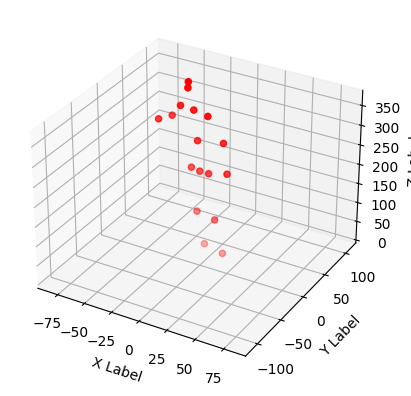

In [108]:
json_file = r'C:\Users\ckim0024\Project\mmpose\output\predictions\prep_bright_tap_3d.json'
plot_3dkeypoints(json_file,'video',1000, space_size = (180, 240, 380))

- all frames (video)

In [2]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import ffmpeg

def plot_3dkeypoints(ax, keypoints, space_size):
    # 공간 크기에 맞게 좌표 스케일링
    x = [-kp[0] * (space_size[0] / 2) for kp in keypoints]
    y = [kp[1] * (space_size[1] / 2) for kp in keypoints]
    z = [kp[2] * space_size[2] for kp in keypoints]
    
    # 키포인트 플로팅
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-space_size[0] / 2, space_size[0] / 2])
    ax.set_ylim([-space_size[1] / 2, space_size[1] / 2])
    ax.set_zlim([0, space_size[2]])

def update(frame_number, json_data, ax, space_size):
    ax.cla()
    keypoints = json_data[frame_number]['instances'][0]['keypoints']
    plot_3dkeypoints(ax, keypoints, space_size)

def create_video_from_keypoints(json_file, output_file, space_size):
    with open(json_file) as f:
        json_data = json.load(f)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    anim = FuncAnimation(fig, update, frames=len(json_data), fargs=(json_data, ax, space_size))
    anim.save(output_file, fps=100, extra_args=['-vcodec', 'libx264'])
    plt.close()

# 예제 사용법
json_file = r'C:\Users\ckim0024\Project\mmpose\output\predictions\prep_bright_tap_3d.json'
output_file = r'C:\Users\ckim0024\Project\mmpose\output\visualizations\prep_bright_tap_manual.mp4'
space_size = (180, 240, 380)
create_video_from_keypoints(json_file, output_file, space_size)


In [12]:
import json
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import cv2

def plot_3dkeypoints(ax, keypoints, space_size):
    # 공간 크기에 맞게 좌표 스케일링
    x = [-kp[0] * (space_size[0] / 2) for kp in keypoints]
    y = [kp[1] * (space_size[1] / 2) for kp in keypoints]
    z = [kp[2] * space_size[2] for kp in keypoints]
    
    # 키포인트 플로팅
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-space_size[0] / 2, space_size[0] / 2])
    ax.set_ylim([-space_size[1] / 2, space_size[1] / 2])
    ax.set_zlim([0, space_size[2]])

def update(frame_number, json_data, ax1, ax2, space_size, video_cap):
    ax1.cla()
    ax2.cla()
    
    # 원본 영상 표시 (반시계방향으로 90도 회전)
    video_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = video_cap.read()
    if ret:
        frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
        ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax1.axis('off')
    
    # 키포인트 표시
    keypoints = json_data[frame_number]['instances'][0]['keypoints']
    plot_3dkeypoints(ax2, keypoints, space_size)

def create_video_from_keypoints(json_file, video_file, output_file, space_size):
    with open(json_file) as f:
        json_data = json.load(f)
    
    video_cap = cv2.VideoCapture(video_file)
    frame_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')
    
    anim = FuncAnimation(fig, update, frames=frame_count, fargs=(json_data, ax1, ax2, space_size, video_cap))
    anim.save(output_file, fps=100, extra_args=['-vcodec', 'libx264'])
    plt.close()
    video_cap.release()


# 예제 사용법
json_file = r'C:\Users\ckim0024\Project\mmpose\output\predictions\prep_bright_tap_3d.json'
output_file = r'C:\Users\ckim0024\Project\mmpose\output\visualizations\prep_bright_tap_both.mp4'
video_file = r'C:\Users\ckim0024\Project\mmpose\data\bright_tap.mp4'

space_size = (180, 240, 380)
create_video_from_keypoints(json_file, video_file, output_file, space_size)


make gif

In [4]:
from moviepy.editor import *
clip = (VideoFileClip(r"C:\Users\ckim0024\Project\mmpose\output\visualizations\prep_bright_tap_manual.mp4"))
clip.write_gif(r"C:\Users\ckim0024\Project\mmpose\output\visualizations\prep_bright_tap_manual.gif", fps=200) #초당 15프레임으로 설정합니다


180(width) x240(height)x 300(height)

2 . 2D Human Pose Estimation

- inferencer

In [49]:
# # build the inferencer with model alias
# inferencer = MMPoseInferencer('human')

# # build the inferencer with model config name
# inferencer = MMPoseInferencer('td-hm_hrnet-w32_8xb64-210e_coco-256x192')

# build the inferencer with model config path and checkpoint path/URL
inferencer2d = MMPoseInferencer(
    pose2d='configs/body_2d_keypoint/topdown_heatmap/coco/' \
           'td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    pose2d_weights='https://download.openmmlab.com/mmpose/top_down/' \
                   'hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth'
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


Downloading: "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth" to C:\Users\ckim0024/.cache\torch\hub\checkpoints\hrnet_w32_coco_256x192-c78dce93_20200708.pth


07/12 23:14:28 - mmengine - WARNING - dataset_meta are not saved in the checkpoint's meta data, load via config.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth


In [50]:
from mmpose.apis import MMPoseInferencer
import cv2
os.environ['KMP_DUPLICATE_LIB_OK']='True'

video_path = 'data/prep_bright_tap.mp4'
result_generator = inferencer2d(video_path, show=False, out_dir='output')
results = [result for result in result_generator]

07/12 23:22:06 - mmengine - INFO - the output video has been saved at output/visualizations\prep_bright_tap.mp4


In [69]:
# 키포인트 추출
import json

def plot_2dkeypoints(json_file,type,frame_number = None):
    if type == 'image':
        keypoints = json.load(open(json_file))[0]['keypoints']
    elif type == 'video':
        keypoints = json.load(open(json_file))[frame_number]['instances'][0]['keypoints']
    
    x = [kp[0] for kp in keypoints]
    y = [kp[1] for kp in keypoints]
    
    # 3D 플롯 생성
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # 키포인트 플로팅
    ax.scatter(x, y, c='r', marker='o')
    
    # 축 레이블 설정
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    
    # 축 범위 설정 (실제 공간 사이즈에 맞게 조정)
    plt.show()

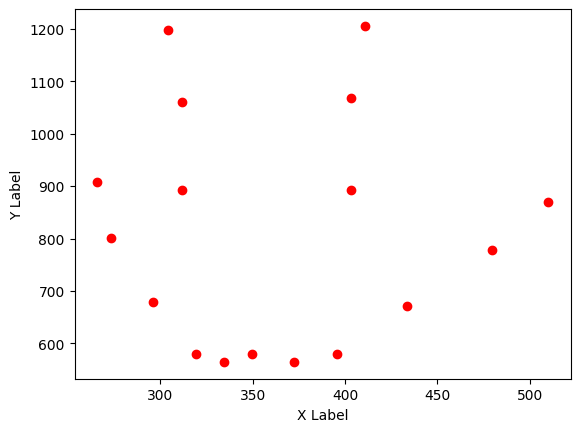

In [70]:
json_file2 = r'C:\Users\ckim0024\Project\mmpose\output\predictions\prep_bright_tap_2d.json'
plot_2dkeypoints(json_file2,'video',10)